## Import Modules

In [1]:
import numpy as np
import os
import pickle
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, add

In [2]:
# Setting up Base Directory
BASE_DIR = r'C:\Users\rajat\OneDrive\Desktop\Tensorflow\ImageCaptioning\dataset1'
WORKING_DIR = r'C:\Users\rajat\OneDrive\Desktop\Tensorflow\ImageCaptioning'

## Load VGG 16 Model (Extracting Features of Images)

In [3]:
# loading the model
model = VGG16()
# restructuring the model
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
# summarize the model
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
# Extracting features into a dictionary
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for image_name in tqdm(os.listdir(directory)):
    # load image from folder
    img_path = directory + '/' + image_name
    img = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    img = img_to_array(img)
    # reshaping the img data
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    # preprocess img for VGG16
    img = preprocess_input(img)
    # get the features
    feature = model.predict(img, verbose=0)
    # get iamge id
    img_id = image_name.split('.')[0]
    # storing it the dictionary
    features[img_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [5]:
# Save the features in a pickle file 
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
# Load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

In [7]:
# loding the data
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
captions_doc

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n1002674143_1b742ab4b8.j

In [9]:
# create mapping of image to captions
description = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # Split the line by ','
    tokens = line.split(',')
    if len(line) < 2:
        continue
    img_id, img_desc = tokens[0], tokens[1:]
    # remove .jpg extension from image id
    img_id, _ = img_id.split(".")
    # Converet Captions list to string
    caption = " ".join(img_desc)
    # create list if needed
    if img_id not in description:
        description[img_id] = []
    # store the caption
    description[img_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [10]:
len(description)

8091

## Preprocess Text Data

In [11]:
def clean_txt(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            # preprocessing steps
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join(word for word in caption.split() if len(word) > 1) + ' endseq'
            captions[i] = caption

In [12]:
# Before preprocess of text 
description['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [13]:
# After preprocessing
clean_txt(description)
description['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## Creating a Tokenizer

In [14]:
all_captions = []
for key in description:
    for caption in description[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

40455

In [16]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [17]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
# checking the vocab size
vocab_size

8485

In [19]:
# Get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [20]:
img_ids = list(description.keys())
split = int(len(img_ids) * 0.90)
split

7281

In [21]:
train = img_ids[:split]
test = img_ids[split:]

## Creating a data generator

TO Get data in Batches abd avoid Session Crash

In [22]:
def data_gen(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into x, y pairs
                for i in range(1, len(seq)):
                    # split into input and output sequence
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence 
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode the output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creatiion

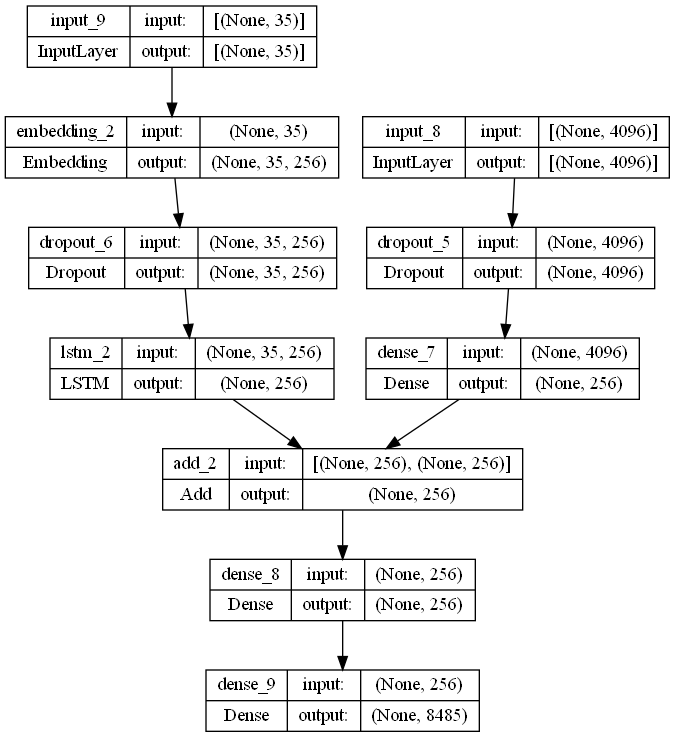

In [27]:
# Creating the Encoder Model
import tensorflow as tf
# Image Feature Layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation="relu")(fe1)
# Sequence Feature Layers
inputs2 = Input(shape=(max_length,))
se1 = tf.keras.layers.Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Creatig the Decoder Model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation="relu")(decoder1)
outputs = Dense(vocab_size, activation="softmax")(decoder2)

# Creating the Model
model_2 = Model(inputs = [inputs1, inputs2], outputs = outputs, name = "CNN_LSTM")

# Compilong the model
model_2.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

# Plot the model
plot_model(model_2, show_shapes=True)

In [28]:
# Train model
epochs = 50
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_gen(train, description, features, tokenizer, max_length, vocab_size, batch_size)
    # fit the model for one epoch
    model_2.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 51s 223ms/step - loss: 2.4749


In [70]:
# save the model
model_2.save('CNN_LSTM_1.h5')

## Generate Captions for the image

In [29]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [30]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    # Iterate over max_length of sequences
    for i in range(max_length):
        # Encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model_2.predict([image, sequence], verbose = 0)
        # Get index with highest prob
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [31]:
from nltk.translate.bleu_score import corpus_bleu

# Validate with Test Data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = description[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split to words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# Calculate BLEU Score
print("BLEU-1 %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2 %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1 0.566015
BLEU-2 0.339769


## Visualize the Results

In [32]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(img_name):
    # Load the image
        #img_name = "410413536_11f1127c46.jpg"
    img_id, _ = img_name.split(".")
    img_path = os.path.join(BASE_DIR, "Images", img_name)
    img = Image.open(img_path)

    captions = description[img_id]
    print('-----------------ACTUAL------------------')
    for caption in captions:
        print(caption)
    # Predict the caption
    y_pred = predict_caption(model, features[img_id], tokenizer, max_length)
    print('---------------PREDICTED-----------------')
    print(y_pred)
    plt.imshow(img)

-----------------ACTUAL------------------
startseq brown dog and tan dog run on beach endseq
startseq dogs chase each other through water endseq
startseq the black dog and the brown dog are on the ground endseq
startseq two dogs play in shallow water endseq
startseq two dogs running on the beach endseq
---------------PREDICTED-----------------
startseq two dogs are playing in the water endseq


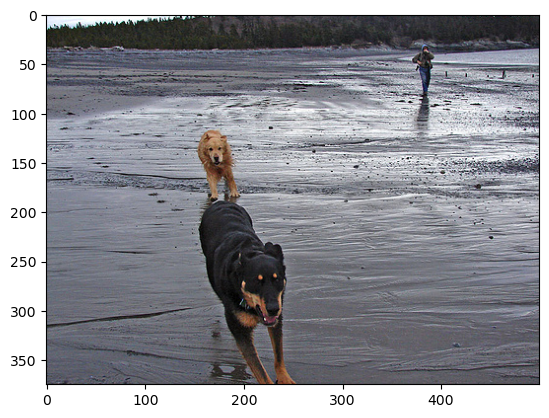

In [35]:
img_name = "3650986674_3e101c606b.jpg"
#img_name = "410413536_11f1127c46.jpg"
#img_name = "571507143_be346225b7.jpg"
generate_caption(img_name)

In [36]:
model_2.save('CNN_LSTM_2.h5')